In [1]:
import numpy as np
import glob
import os
%matplotlib inline
from readTRC import readTrc
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly


import matplotlib.mlab as mlab
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from collections import OrderedDict

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FILE_SORTER(files):
    FilesGold   = []
    FilesSignal = []
    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    FilesGold.sort(); FilesSignal.sort()
    return FilesGold, FilesSignal

def MEAN_WAVEFORM(PATH,files):
    #folders[F]+FilesSignal[0]
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(10002)
    Xvals = np.zeros(10002)
    avg = 0
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    return MSigX,MSigY

def WAVEFORM_QUALITY(PATH,files,MEAN,CHI):
    
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(10002)
    Xvals = np.zeros(10002)
    avg = 0
    #for w in range(0,1100):
    CHII = []
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[:Trigger])
            Bs    = np.mean(B[:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            if chi <CHI:
                Yvals += Y
                Xvals += X
                avg   += 1
                CHII.append(chi)
        if avg != 0:
            SigY = Yvals/avg
            SigX = Xvals/avg
        else:
            SigY = Yvals
            SigX = Xvals 
        
    #CHI=np.array(CHI)
    return SigX,SigY,CHII

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-100
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-100
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [5]:
FOLD = ['100/','035/','015/','008/','002/','000/']
SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[0]
PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[0]
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

In [6]:
NAME

NameError: name 'NAME' is not defined

In [7]:
P = int(NAME.split('_')[1].split('-')[-1])
P

NameError: name 'NAME' is not defined

Xe-100_P-01_E-080
Xe-100_P-01_E-100
OPT high G =  [8.76107498e-06 1.60476730e-06 2.21717390e-03 1.10604559e-04]
OPT high S =  [ 1.50059352e-04  5.72163395e-06 -1.50362401e-04  2.01408574e-06]
G chi =  1.2948339782179057
A chi =  0.14513803208901077
Xe-100_P-01_E-150
Xe-100_P-01_E-200
Xe-100_P-01_E-250
Xe-100_P-01_E-300
Xe-100_P-03_E-080
Xe-100_P-03_E-100
OPT high G =  [9.31278358e-06 1.93138023e-06 1.47070240e-03 2.67184995e-05]
OPT high S =  [ 1.76650690e-04  6.64046053e-06 -2.13270618e-04  1.13287338e-05]
G chi =  0.7851965273803937
A chi =  0.21290332876651755
Xe-100_P-03_E-150
Xe-100_P-03_E-200
Xe-100_P-03_E-250
Xe-100_P-03_E-300
Xe-100_P-06_E-080
Xe-100_P-06_E-100
OPT high G =  [ 9.70092967e-06  2.10274326e-06  1.14545578e-03 -1.72187917e-05]
OPT high S =  [ 2.22547787e-04  8.38172046e-06 -2.70007115e-04  3.32850042e-06]
G chi =  0.8132903279231948
A chi =  0.15529104168132513
Xe-100_P-06_E-150
Xe-100_P-06_E-200
Xe-100_P-06_E-250
Xe-100_P-06_E-300
Xe-100_P-09_E-080
Xe-100_P-09_E-1

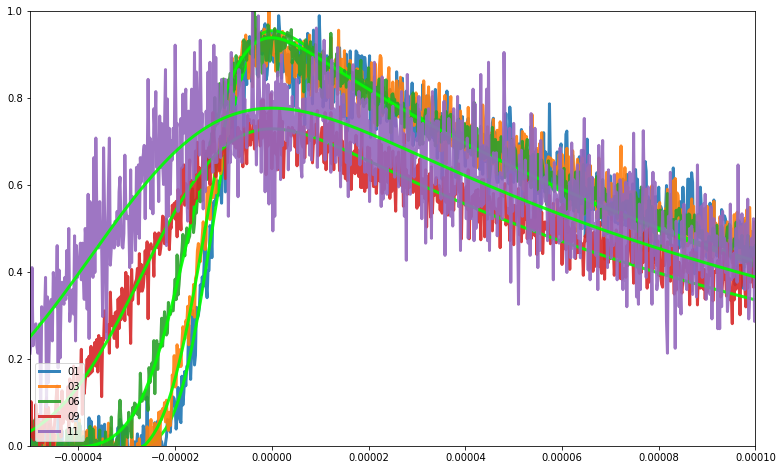

In [8]:
ChG = []
ChS = []
#for per in range(0,len(FOLD)):
for per in [0]:

    #SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    plt.figure(figsize=(13,8))
    
    for F in range(0,len(folders)):
    #for F in [5]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        E = int(NAME.split('-')[-1])
        P = NAME.split('_')[1].split('-')[-1]

        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')
        CHI = 10
        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
        

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        
        #ChG.append(ChiG)
        #ChS.append(ChiS)
        
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        XVALS  = Gx
        YVALSG = Gy-baselineG
        YVALSS = Sy-baselineS


        if np.mean(np.nan_to_num(YVALSG))!=0 and np.mean(np.nan_to_num(YVALSS))!=0 and E == 100:
            xa,ya,opta,chia = FITTER_ANOD(XVALS,YVALSS)
            xg,yg,optg,chig = FITTER_GOLD(XVALS,YVALSG)
            V = 15/((opta[0]-optg[0]))
            V = V**(3/2)
            #plt.plot(xa*V,funcA(xa,*opta),color='lime',alpha=0.9,linewidth=3)
            #plt.plot(xg*V,funcG(xg,*optg),color='r',alpha=0.9,linewidth=3)
            Nor = min(ya)
            MinArg=np.argmin(funcA(xa,*opta))
            xa1=xa-xa[MinArg]
            plt.plot(xa1,ya/Nor,alpha=0.9,linewidth=3,label=P)
            plt.plot(xa1,funcA(xa,*opta)/Nor,color='lime',alpha=0.9,linewidth=3)

            #plt.plot(xg*V,yg*V,color='r',alpha=0.9,linewidth=3)
            print("OPT high G = ",optg)
            print("OPT high S = ",opta)
            print("G chi = ",chig*1e6)
            print("A chi = ",chia*1e6)
        
            #plt.xlim(0,0.0010)
            #plt.xlim(0,0.00070)
            #plt.xlim(0,.000040)
            plt.xlim(-5e-5,1e-4)
            plt.ylim(0,1)
            #plt.ylim(-100,10)
            plt.legend(loc="lower left")
    plt.show()
        
        
        
        #data = [Gx, Gy-baselineG, Sy-baselineS]
        #np.savetxt(SPATH+NAME+'.txt',data)

Xe-100_P-01_E-080
Xe-100_P-01_E-100
OPT high G =  [8.76107498e-06 1.60476730e-06 2.21717390e-03 1.10604559e-04]
OPT high S =  [ 1.50059352e-04  5.72163395e-06 -1.50362401e-04  2.01408574e-06]
G chi =  1.2948339782179057
A chi =  0.14513803208901077
Xe-100_P-01_E-150
Xe-100_P-01_E-200
Xe-100_P-01_E-250
Xe-100_P-01_E-300
Xe-100_P-03_E-080
Xe-100_P-03_E-100
OPT high G =  [9.31278358e-06 1.93138023e-06 1.47070240e-03 2.67184995e-05]
OPT high S =  [ 1.76650690e-04  6.64046053e-06 -2.13270618e-04  1.13287338e-05]
G chi =  0.7851965273803937
A chi =  0.21290332876651755
Xe-100_P-03_E-150
Xe-100_P-03_E-200
Xe-100_P-03_E-250
Xe-100_P-03_E-300
Xe-100_P-06_E-080
Xe-100_P-06_E-100
OPT high G =  [ 9.70092967e-06  2.10274326e-06  1.14545578e-03 -1.72187917e-05]
OPT high S =  [ 2.22547787e-04  8.38172046e-06 -2.70007115e-04  3.32850042e-06]
G chi =  0.8132903279231948
A chi =  0.15529104168132513
Xe-100_P-06_E-150
Xe-100_P-06_E-200
Xe-100_P-06_E-250
Xe-100_P-06_E-300
Xe-100_P-09_E-080
Xe-100_P-09_E-1

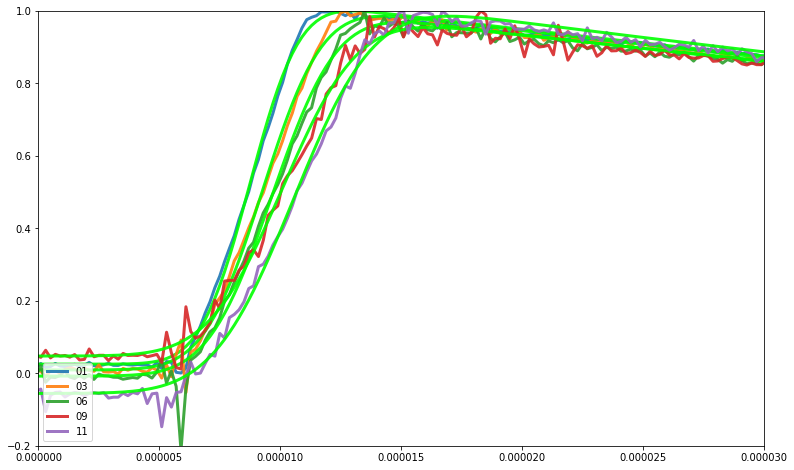

In [12]:
ChG = []
ChS = []
#for per in range(0,len(FOLD)):
for per in [0]:

    #SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    plt.figure(figsize=(13,8))
    
    for F in range(0,len(folders)):
    #for F in [5]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        E = int(NAME.split('-')[-1])
        P = NAME.split('_')[1].split('-')[-1]

        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')
        CHI = 10
        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
        

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        
        #ChG.append(ChiG)
        #ChS.append(ChiS)
        
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        XVALS  = Gx
        YVALSG = Gy-baselineG
        YVALSS = Sy-baselineS


        if np.mean(np.nan_to_num(YVALSG))!=0 and np.mean(np.nan_to_num(YVALSS))!=0 and E == 100:
            xa,ya,opta,chia = FITTER_ANOD(XVALS,YVALSS)
            xg,yg,optg,chig = FITTER_GOLD(XVALS,YVALSG)
            V = 15/((opta[0]-optg[0]))
            V = V**(3/2)
            #plt.plot(xa*V,funcA(xa,*opta),color='lime',alpha=0.9,linewidth=3)
            #plt.plot(xg*V,funcG(xg,*optg),color='r',alpha=0.9,linewidth=3)
            Nor = max(yg)
            MinArg=np.argmax(funcG(xg,*optg))
            xg1=xg#-xg[MinArg]
            plt.plot(xg1,yg/Nor,alpha=0.9,linewidth=3,label=P)
            plt.plot(xg1,funcG(xg,*optg)/Nor,color='lime',alpha=0.9,linewidth=3)

            #plt.plot(xg*V,yg*V,color='r',alpha=0.9,linewidth=3)
            print("OPT high G = ",optg)
            print("OPT high S = ",opta)
            print("G chi = ",chig*1e6)
            print("A chi = ",chia*1e6)
        
            #plt.xlim(0,0.0010)
            #plt.xlim(0,0.00070)
            #plt.xlim(0,.000040)
            plt.xlim(-1e-5,1e-5)
            plt.xlim(0,3e-5)
            plt.ylim(-0.2,1)
            #plt.ylim(-100,10)
            plt.legend(loc="lower left")

    plt.show()
        
        
        
        #data = [Gx, Gy-baselineG, Sy-baselineS]
        #np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
chig

In [ ]:
len(ChG)

In [ ]:
plt.hist(ChG[50],bins=np.linspace(0,10,50),alpha=0.6,label="Gold")
plt.hist(ChS[50],bins=np.linspace(0,10,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,6)
plt.axvline(0.75,color="r")
plt.axvline(1,color="lime")
plt.show()

In [ ]:
ChGF = [item for sublist in ChG for item in sublist]
ChSF = [item for sublist in ChS for item in sublist]

In [ ]:
plt.hist(ChGF,bins=np.logspace(-2,4,100),alpha=0.6,label="Gold")
plt.hist(ChSF,bins=np.logspace(-2,4,100),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.loglog()
#plt.xlim(0,6)
#plt.axvline(0.75,color="r")
#plt.axvline(1,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()
plt.hist(ChGF,bins=np.linspace(0,2,100),alpha=0.6,label="Gold")
plt.hist(ChSF,bins=np.linspace(0,2,100),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,2)
#plt.axvline(0.75,color="r")
plt.axvline(0.7,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()

In [ ]:
for per in range(0,len(FOLD)):

    SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data-3/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    
    CHI = 0.7
    CHI = 20
    for F in range(0,len(folders)):
    #for F in [0]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')

        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,C = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,C = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)

        TriggerTime = find_nearest(Sx,0)
        Trigger     = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        data = [Gx, Gy-baselineG, Sy-baselineS]
        np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
MEAN

In [ ]:
FOLD = ['100/','099/','098/','097/','096/','095/','093/','090/','085/']
FF = 1
SPATH = '/Users/austinmcdonald/Desktop/XeHe/Data/'+FOLD[FF]
PATH = '/Users/austinmcdonald/Desktop/XeHe/'+FOLD[FF]
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

In [ ]:
CHI = 1
for F in range(0,len(folders)):
#for F in [0]:
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
    Gx,Gy = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
    
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
    Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
    
    TriggerTime = find_nearest(Sx,0)
    Trigger     = np.where(Sx==TriggerTime)[0][0]
    baselineS    = np.mean(Sy[0:Trigger])
    baselineG    = np.mean(Sy[0:Trigger])
    data = [Gx, Gy-baselineG, Sy-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
Sx

In [ ]:
EH = []
PATH = folders[F]
files = FS
Yvals = np.zeros(10002)
Xvals = np.zeros(10002)
avg = 0
#for w in range(0,1100):
for w in range(0,len(files)):

    X, Y, info = readTrc(PATH+files[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        A = moving_average(MEAN,10)
        B = moving_average(Y   ,10)
        D = moving_average(X   ,10)
        TriggerTime = find_nearest(D,0)
        Trigger     = np.where(D==TriggerTime)[0][0]
        As    = np.mean(A[:Trigger])
        Bs    = np.mean(B[:Trigger])

        holder = ((A-As)-(B-Bs))**2
        chi = np.sum(holder)*1e4
        EH.append(chi)
        if chi <100:
            Yvals += Y
            Xvals += X
            avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg

In [ ]:
plt.plot(SigX,SigY)

In [ ]:
plt.hist(EH)

In [ ]:
EH = []
CHI = 2
#for F in range(0,len(folders)):
AHHH = "/Users/austinmcdonald/Desktop/XeHe/099/Xe-099_P-10_E-350/"
#print(folders[F])
NAME = AHHH.split('/')[-2]
print(NAME)
files = os.listdir(AHHH)
FG,FS = FILE_SORTER(files)
Mx,MEAN = MEAN_WAVEFORM(AHHH,FS)



X, Y, info = readTrc(AHHH+FS[1])
Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FS)):

    X, Y, info = readTrc(AHHH+FS[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        A = moving_average(MEAN,10)
        B = moving_average(Y   ,10)
        D = moving_average(X   ,10)
        TriggerTime = find_nearest(D,0)
        Trigger     = np.where(D==TriggerTime)[0][0]
        As    = np.mean(A[0:Trigger])
        Bs    = np.mean(B[0:Trigger])

        holder = ((A-As)-(B-Bs))**2
        chi = np.sum(holder)*1e4
        print(chi)
        plt.figure(figsize=(6,6))
        plt.plot(D,A-As)
        plt.plot(D,B-Bs)
        plt.show()

        EH.append(chi)

        if chi <3:
            Yvals += Y
            Xvals += X
            avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg



In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]

In [ ]:
Trigger

In [ ]:
plt.plot(SigX,SigY)

In [ ]:
files = os.listdir(AHHH)
FG,FS = FILE_SORTER(files)

#X, Y, info = readTrc(AHHH+FG[0])
#Yvals = np.zeros(X.shape[0])
#Xvals = np.zeros(Y.shape[0])
Yvals = np.zeros(10002)
Xvals = np.zeros(10002)
avg = 0
for w in range(0,len(FG)):

    X, Y, info = readTrc(AHHH +FG[w])
    print(X.shape)

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MSigY = Yvals/avg
MSigX = Xvals/avg

In [ ]:
Xvals.shape

In [ ]:
plt.plot(MSigX,MSigY)

In [ ]:
SPATH = '/Users/austinmcdonald/Desktop/Xenon/Data/100-2/'
PATH = '/Users/austinmcdonald/Desktop/Xenon/100-2/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

In [ ]:
len(folders)

In [ ]:
CHI = 2
for F in range(0,len(folders)):
    #print(folders[F])
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    
    FilesGold   = []
    FilesSignal = []

    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    X, Y, info = readTrc(folders[F]+FilesSignal[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,len(FilesSignal)):

        X, Y, info = readTrc(folders[F]+FilesSignal[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    
    
    X, Y, info = readTrc(folders[F]+FilesSignal[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(FilesSignal)):

        X, Y, info = readTrc(folders[F]+FilesSignal[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            CC = moving_average((MSigY-Y),1)
            xx = moving_average(X,50)
            chiH = CC**2
            chi = np.sum(chiH)*1000
            if chi <CHI:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg
    print("Sig avg",avg)

    
    X, Y, info = readTrc(folders[F]+FilesGold[0])

    avg = 0
    for w in range(0,len(FilesGold)):

        X, Y, info = readTrc(folders[F]+FilesGold[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MGolY = Yvals/avg
    MGolX = Xvals/avg
    
    
    X, Y, info = readTrc(folders[F]+FilesGold[0])  
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0 
    #for w in range(0,1100):
    for w in range(0,len(FilesGold)):
        X, Y, info = readTrc(folders[F]+FilesGold[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            CC = moving_average((MGolY-Y),1)
            xx = moving_average(X,50)
            EE = np.mean(CC)
            chiH = (CC-EE)**2
            chi = np.sum(chiH)*1000
            if chi <CHI:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
    GolY = Yvals/avg
    GolX = Xvals/avg
    print("Gol avg",avg)


    TriggerTime = find_nearest(SigX,0)
    Trigger     = np.where(SigX==TriggerTime)[0][0]
    baselineS    = np.mean(SigY[0:Trigger])
    baselineG    = np.mean(GolY[0:Trigger])
    data = [(GolX), GolY-baselineG, SigY-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)
    #print("DONE!")

In [ ]:
def FILE_SORTER(files):
    FilesGold   = []
    FilesSignal = []
    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    FilesGold.sort(); FilesSignal.sort()
    return FilesGold, FilesSignal

def MEAN_WAVEFORM(PATH,files):
    #folders[F]+FilesSignal[0]
    X, Y, info = readTrc(PATH+files[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    return MSigX,MSigY

def WAVEFORM_QUALITY(PATH,files,MEAN,CHI):
    
    X, Y, info = readTrc(PATH+files[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[0:Trigger])
            Bs    = np.mean(B[0:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            if chi <CHI:
                Yvals += Y
                Xvals += X
                avg   += 1
        SigY = Yvals/avg
        SigX = Xvals/avg
    return SigX,SigY

In [ ]:
FG,FS = FILE_SORTER(files)

In [ ]:
Mx,My = MEAN_WAVEFORM(folders[F],FG)

In [ ]:
FOLD = '100/'
SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD
PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

In [ ]:
CHI = 1
for F in range(0,len(folders)):
#for F in [0]:
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
    Gx,Gy = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
    
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
    Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
    
    TriggerTime = find_nearest(Sx,0)
    Trigger     = np.where(Sx==TriggerTime)[0][0]
    baselineS    = np.mean(Sy[0:Trigger])
    baselineG    = np.mean(Sy[0:Trigger])
    data = [Gx, Gy-baselineG, Sy-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
plt.plot(Sx,Sy)

In [ ]:
EH = []
CHI = 2
#for F in range(0,len(folders)):
for F in [0]:

#print(folders[F])
    NAME = '/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'.split('/')[-2]
    print(NAME)
    files = os.listdir('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/')
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/',FG)
    
    
    
    X, Y, info = readTrc('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'+FG[1])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(FS)):

        X, Y, info = readTrc('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'+FG[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[0:Trigger])
            Bs    = np.mean(B[0:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            print(chi)
            plt.figure(figsize=(6,6))
            plt.plot(D,A-As)
            plt.plot(D,B-Bs)
            plt.show()
        
            EH.append(chi)

            if chi <1:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
        SigY = Yvals/avg
        SigX = Xvals/avg
            


In [ ]:
MEAN

In [ ]:
np.linspace(0,1,10)

In [ ]:
plt.hist(EH,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
plt.plot(SigX,SigY)
plt.plot(Sx,Sy)

In [ ]:
eh = '/Users/austinmcdonald/Desktop/Xenon/100-2/Xe-100_P-11_E-100/C1electron00026.trc'
X, Y, info = readTrc(eh)
plt.plot(X,Y,color='g')


In [ ]:
TriggerTime = find_nearest(GolX,0)
Trigger     = np.where(GolX==TriggerTime)[0][0]+35

T2 = find_nearest(GolX,0.00125)
T2 = np.where(GolX==T2)[0][0]
plt.plot(GolX,GolY,color='g')
plt.plot(SigX,SigY,color='r')
plt.plot(GolX[Trigger:T2],GolY[Trigger:T2],color='k')
#plt.xlim(-0.00001,0.00001)

In [ ]:
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20

In [ ]:
Trigger

In [ ]:
T2

In [ ]:
[1034:7249]

In [ ]:
mm=[]
F=-1
files = os.listdir(folders[F])

FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

X, Y, info = readTrc(folders[F]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MSigY = Yvals/avg
MSigX = Xvals/avg


X, Y, info = readTrc(folders[F]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,11):
for w in range(0,len(FilesGold)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        CC = moving_average((MSigY-Y),1)
        xx = moving_average(X,1)
        EE = np.mean(CC)
        chiH = (CC-EE)**2
        chi = np.sum(chiH)*1000

        #coefs = poly.polyfit(xx, CC, 1)
        #ffit = poly.polyval(xx, coefs)
        #chi = abs(chisquare(CC, f_exp=ffit)[0])
        print(chi)
  
        plt.plot(xx,CC)
        #plt.plot(xx,ffit)

        plt.show()
        mm.append(chi)
        if chi <1:
            #mm.append(chi)
            Yvals += Y
            Xvals += X
            avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg
print("Sig avg",avg)

In [ ]:
plt.hist(mm,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
plt.plot(SigX,SigY)
#plt.plot(MSigX,MSigY)

In [ ]:
plt.plot(SigX,MSigY-SigY)
#plt.plot(MSigX,MSigY)

In [ ]:
plt.plot(MSigX[Trigger:T2],MSigY[Trigger:T2])

In [ ]:
from scipy import stats
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [ ]:
import numpy.polynomial.polynomial as poly

#coefs = poly.polyfit(x, y, 4)
#ffit = poly.polyval(x_new, coefs)

In [ ]:
F=-1   #print(folders[F])
NAME = folders[F].split('/')[-2]
NAME

In [ ]:
F = 3
files = os.listdir(folders[F])

FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])
mm=[]

X, Y, info = readTrc(folders[F]+FilesGold[0])




avg = 0
for w in range(0,len(FilesGold)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MGolY = Yvals/avg
MGolX = Xvals/avg


X, Y, info = readTrc(folders[F]+FilesGold[0])  


Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,10):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[F]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        CC = moving_average((MGolY-Y),50)
        xx = moving_average(X,50)
        coefs = poly.polyfit(xx, CC, 1)
        ffit = poly.polyval(xx, coefs)
        chi = abs(chisquare(CC, f_exp=ffit)[0])
        print(chi)
        plt.plot(xx,CC)
        plt.plot(xx,ffit)
        plt.show()
        mm.append(chi)

        if chi <0.5:
            #mm.append(chi)
            Yvals += Y
            Xvals += X
            avg   += 1
GGolY = Yvals/avg
GGolX = Xvals/avg

In [ ]:
avg

In [ ]:
plt.plot(GolX,GolY,alpha=0.4)
plt.plot(GGolX,GGolY,color='r')


In [ ]:
plt.plot(GolX,GolY,alpha=0.4)


In [ ]:
#SSigX3 =SSigX
#SSigY3 =SSigY

plt.plot(SSigX,SSigY,color='r')

plt.plot(SigX,SigY,alpha=0.4)


In [ ]:
plt.plot(SigX,SigY-Y)
plt.plot(X,Y)

In [ ]:
np.linspace(0,10,100)

In [ ]:
plt.hist(mm,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
mm

In [ ]:
AH = 3
files = os.listdir(folders[AH])
len(files)

In [ ]:
FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesSignal[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[AH]+FilesSignal[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg

X, Y, info = readTrc(folders[AH]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[AH]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
GolY = Yvals/avg
GolX = Xvals/avg

In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]
baselineS    = np.mean(SigY[0:Trigger])
baselineG    = np.mean(GolY[0:Trigger])
data = [GolX, GolY-baselineG, SigY-baselineS]
np.savetxt(PATH+"test"+'.txt',data)

In [ ]:
plt.plot(GolX,SigY-baselineS+0.001)
plt.plot(GolX,GolY-baselineG)

In [ ]:
AH = 3
Fold = folders[AH].split('/')[-2]
cut = Fold+'/'



files = os.listdir(folders[AH])
#files.remove('.DS_Store')
int(files[4][1])

In [ ]:
Fold

In [ ]:
FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesSignal[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[AH]+FilesSignal[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg

In [ ]:
avg

In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]
baseline    = np.mean(SigY[0:Trigger])
data = [SigX,SigY-baseline]
np.savetxt('/Users/austinmcdonald/Desktop/Xenon-11bar-test/'+"Sig-"+Fold+'.txt',data)

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesGold[1])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[AH]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
GolY = Yvals/avg
GolX = Xvals/avg

In [ ]:
avg

In [ ]:
TriggerTime = find_nearest(GolX,0)
Trigger     = np.where(GolX==TriggerTime)[0][0]
baseline    = np.mean(GolY[0:Trigger])
data = [GolX,GolY-baseline]
np.savetxt('/Users/austinmcdonald/Desktop/Xenon-11bar-test/'+"Gol-"+Fold+'.txt',data)

In [ ]:
for q in range(3,4):
    files = os.listdir(folders[q])
    Name = folders[q].split('/')[-2]
    N = len(files)
    
    X, Y, info = readTrc(folders[q]+files[0])
    
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,N):
        X, Y, info = readTrc(folders[q]+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    Yvals = Yvals/avg
    Xvals = Xvals/avg
    TriggerTime = find_nearest(Xvals,0)
    Trigger     = np.where(Xvals==TriggerTime)[0][0]
    baseline    = np.mean(Yvals[0:Trigger])
    data = [Xvals,Yvals-baseline]
    np.savetxt(PATH+Name+'.txt',data)
    
    

In [ ]:
Yvals

In [ ]:
files = os.listdir()
#files.remove('.DS_Store')


In [ ]:
len(files)

In [ ]:
N = len(files)
Yvals = np.zeros(50e3+2)
Xvals = np.zeros(50e3+2)

for q in range(0,N):
    X, Y, info = readTrc(files[q])
    #Y = np.array(Y)
    Yvals += Y
    Xvals +=X
Yvals = Yvals/N
Xvals = Xvals/N

In [ ]:
find_nearest(Xvals,0)

In [ ]:
TriggerTime = find_nearest(Xvals,0)
Trigger     = np.where(Xvals==TriggerTime)[0][0]
baseline    = np.mean(Yvals[0:Trigger])
baseline

In [ ]:
plt.plot(Xvals,Yvals-baseline)

In [ ]:
data = [Xvals,Yvals-baseline]

In [ ]:
path = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
np.savetxt(path+'050-clean.txt',data)

In [ ]:
AA = np.loadtxt(path+'200clean.txt')
